# Análise Exploratória dos Dados e Pré-Processamento

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps_api

Os dados, vindos do site zapimoveis.com.br, foram coletados e organizados em um csv através do arquivo '1_zapimoveis_scraper.ipynb'. Aqui nós carregamos estes dados:

In [3]:
imoveis_df = pd.read_csv('casas_zapimoveis-13-set-22.csv')
imoveis_df.head()

,endereco,preco,area,quartos,banheiros,garagens
0,"Plano Diretor Norte, Palmas",1000000,112,3,2,4
1,"ARSO 43 Alameda 3, Plano Diretor Sul",625000,150,3,2,2
2,"Quadra ARNE 64 Alameda 2, Plano Diretor Norte",315000,115,3,1,3
3,"Plano Diretor Sul, Palmas",220000,86,2,2,2
4,"Quadra ARSE 92 Alameda 4, Plano Diretor Sul",550000,190,4,2,2


## Pré-Processamento

### Adicionando Latitude e Longitude de cada imóvel

Utilizaremos o endereço de cada imóvel para realizar uma busca no Google Maps, através da API Geocode do próprio Google, e ter como retorno as coordenadas de Latitude e Longitude de cada imóvel. Esses valores servirão de entrada para nosso modelo de Machine Learning futuramente.

In [5]:
# Esta é apenas uma interface para retornar o resultado como uma Series, e assim ser compatível com .apply do Pandas
def lat_long_google_api(enderco_ou_cep):
    
    lat, lng = gmaps_api.busca_coordenadas(enderco_ou_cep)

    return pd.Series({'latitude': lat, 'longitude': lng})

Para cada entrada do nosso DataFrame, executamos a busca de Latitude/Longitude. Esta execução é demorada e PODE GERAR CUSTOS NA SUA CONTA GOOGLE, por isso incluímos uma proteção contra execução não proposital.

In [6]:
EXECUTAR_ESTA_CELULA = False

if(EXECUTAR_ESTA_CELULA):
    
    lat_longs = imoveis_df['endereco'].apply(lat_long_google_api)

    # Guardamos os resultados em novas colunas do DF
    imoveis_df['latitude'] = lat_longs['latitude']
    imoveis_df['longitude'] = lat_longs['longitude']

    # Para não precisar sempre executar essa célula (CUSTOS), guardamos os resultados em um arquivo
    imoveis_df.to_csv('casas_zapimoveis_com_lat_long.csv', index=False)

    imoveis_df.head()

Como a execução da célula acima não é obrigatória, seguimos nossa análisa carregando os dados (com latitude e longitude) de um arquivo:

In [7]:
imoveis = pd.read_csv('casas_zapimoveis_com_lat_long.csv')
print("Shape do dataFrame carregado: ", imoveis.shape)
imoveis.head()

Shape do dataFrame carregado:  (1455, 8)


,endereco,preco,area,quartos,banheiros,garagens,latitude,longitude
0,"Plano Diretor Norte, Palmas",1000000,112,3,2,4,-10.170166,-48.333980
1,"ARSO 43 Alameda 3, Plano Diretor Sul",625000,150,3,2,2,-10.215773,-48.334077
2,"Quadra ARNE 64 Alameda 2, Plano Diretor Norte",315000,115,3,1,3,-10.156889,-48.313459
3,"Plano Diretor Sul, Palmas",220000,86,2,2,2,-10.219647,-48.338964
4,"Quadra ARSE 92 Alameda 4, Plano Diretor Sul",550000,190,4,2,2,-10.215587,-48.346005


### Tratando valores faltantes

Há dados faltantes? Quantos? Como trataremos?

In [8]:
imoveis.isnull().sum()

endereco      0
preco         0
area          0
quartos       0
banheiros     0
garagens      0
latitude     13
longitude    13
dtype: int64

Só temos 13 entradas nulas de latitude/longitude dentre mais de 1550 entradas. Então vamos simplesmente excluí-las

In [9]:
imoveis.dropna(inplace=True)
imoveis.shape

(1442, 8)

## Análise Exploratória de Dados (EDA)

### Como é a distribuição de preços?

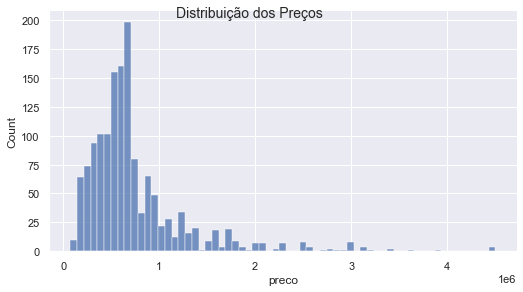

In [10]:
sns.set()
fig = sns.displot(imoveis, x='preco')
_ = fig.figure.set_size_inches(8, 4)
_ = plt.suptitle("Distribuição dos Preços", fontsize = 14)

Pelo histograma vemos claramente que podemos considerar preços acima de 3.5mi como outliers e excluí-los:

In [11]:
imoveis = imoveis[imoveis['preco'] < 3500000]
imoveis.shape

(1436, 8)

### Como é a distribuição de áreas?

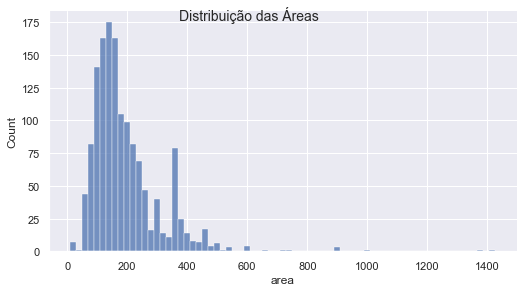

In [12]:
fig = sns.displot(imoveis, x='area')
_ = fig.figure.set_size_inches(8, 4)
_ = plt.suptitle("Distribuição das Áreas", fontsize = 14)

Claramente os imóveis que apresentam área maior que 800 metros quadrados foram mal classificados como casas, portanto podemos eliminá-los da nossa análise:

In [13]:
imoveis = imoveis[imoveis['area'] < 800]
imoveis.shape

(1430, 8)

### Como são as distribuições de quartos, banheiros e garagens?

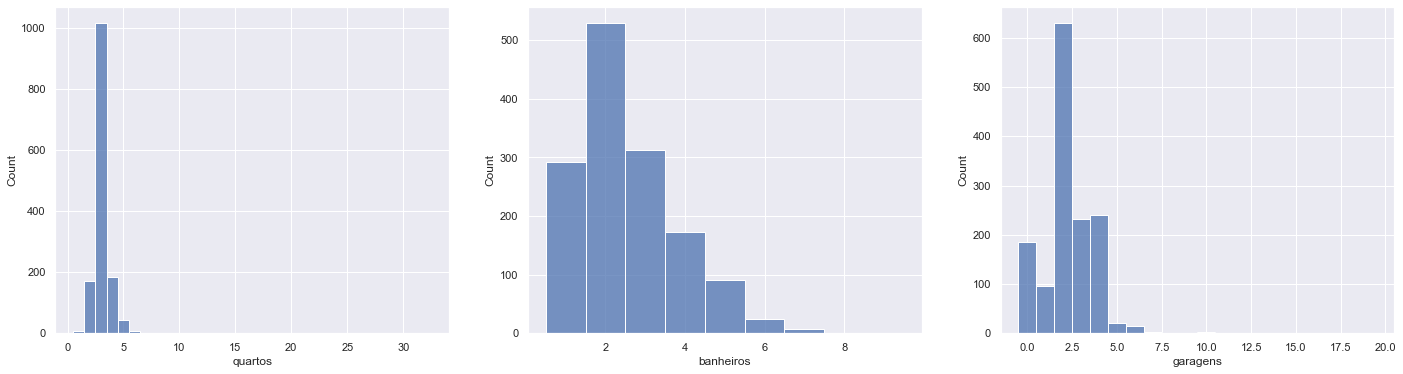

In [14]:
fig, ax = plt.subplots(1,3)
_ = fig.figure.set_size_inches(24,6)
_ = sns.histplot(imoveis, x='quartos', discrete=True, ax=ax[0])
_ = sns.histplot(imoveis, x='banheiros', discrete=True, ax=ax[1])
_ = sns.histplot(imoveis, x='garagens', discrete=True, ax=ax[2])

Pelos gráficos podemos considerar claros outliers: quartos > 7, banheiros > 8 e garagens > 7:

In [15]:
imoveis = imoveis[ (imoveis['quartos']<7) & (imoveis['banheiros']<8) & (imoveis['garagens']<7) ]
imoveis.shape

(1420, 8)

Verificando o resultado, após limpeza:

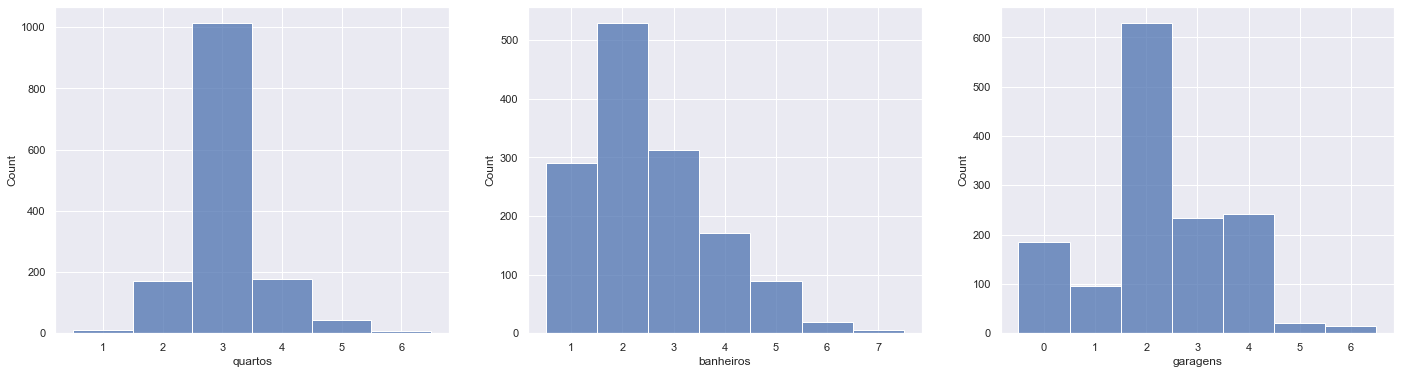

In [16]:
fig, ax = plt.subplots(1,3)
_ = fig.figure.set_size_inches(24,6)
_ = sns.histplot(imoveis, x='quartos', discrete=True, ax=ax[0])
_ = sns.histplot(imoveis, x='banheiros', discrete=True, ax=ax[1])
_ = sns.histplot(imoveis, x='garagens', discrete=True, ax=ax[2])

### As coordenadas espaciais (latitude e longitude) parecem corretas?

Primeiramente abrimos o Google Maps e verificamos as coordenadas de quatro pontos que determinam uma área (aproximada) da cidade de Palmas. Então verificamos que os quatro pontos tem latitude no formato -10.XXXXXX e longitude -48.XXXXXX.
Abaixo vamos verificar quantas coordenada não estão dentro dessas magnitudes:

In [17]:
print("Latitudes erradas: ", len(imoveis[ imoveis['latitude'].apply(lambda x: int(x) != -10) ]))
print("Longitudes erradas: ", len(imoveis[ imoveis['longitude'].apply(lambda x: int(x) != -48) ]))

Latitudes erradas:  11
Longitudes erradas:  10


Portanto teremos no máximo mais 21 entradas excluídas. Vamos excluir e ver quantas são:

In [18]:
print("Número de entradas, antes de excluir: ", imoveis.shape[0])
imoveis = imoveis[imoveis['latitude'].apply(lambda x: int(x) == -10)]
imoveis = imoveis[imoveis['longitude'].apply(lambda x: int(x) == -48)]
print("Número de entradas, depois de excluir: ", imoveis.shape[0])

Número de entradas, antes de excluir:  1420
Número de entradas, depois de excluir:  1409


Agora que excluímos os valores absurdos, vamos plotar as coordenadas:

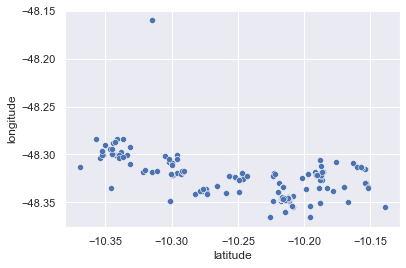

In [19]:
_ = sns.scatterplot(data=imoveis, x='latitude', y='longitude')

Agora identificamos um ponto isolado, que, ao verificarmos pelo Google Maps, este se mostra numa área rural muito afastada da cidade (talvez fazendo parte já de outra) cidade. Por isso vamos eliminar este ponto também:

In [20]:
imoveis = imoveis[imoveis['longitude'] < -48.25]
imoveis.shape

(1407, 8)

### Por fim, há multicolinearidade?

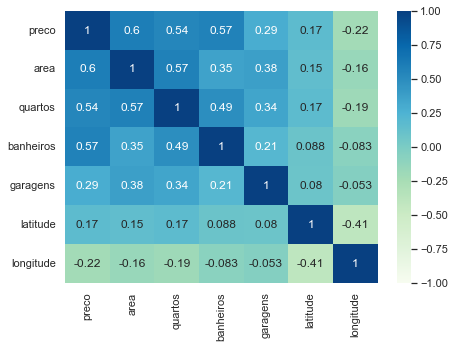

In [21]:
plt.figure(figsize=(7,5))
sns.heatmap(imoveis.corr(),
            vmin = -1, 
            vmax = 1,
            cmap ="GnBu",
            annot=True)
plt.show()

Uma correlação moderada entre preço, área, quartos e banheiros já era esperada, por isso esses parâmetros serão os mais importantes na determinação do preço do imóvel.
A localização do imóvel mostrou fraca correlação com o preço, porém devemos ter em mente que a maioria dos imóveis levantados aparecem com um endereço genérico, como "Plano Diretor Sul, Palmas".

## Concluindo a EDA e o Pré-Processamento

Iniciamos nossa análise com 1455 entradas e finalizamos com 1407, uma redução de apenas 3.3%, portanto perdemos muito pouca informação no processo. Veja abaixo um panorama dos valores do dataframe final:

In [22]:
imoveis.describe()

,preco,area,quartos,banheiros,garagens,latitude,longitude
count,1.407000e+03,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000,1407.000000
mean,7.235935e+05,187.903340,3.064677,2.520256,2.263682,-10.220257,-48.336406
std,4.892076e+05,99.237759,0.647302,1.238653,1.290951,0.031131,0.010300
min,7.500000e+04,10.000000,1.000000,1.000000,0.000000,-10.369013,-48.365767
25%,4.470000e+05,120.000000,3.000000,2.000000,2.000000,-10.219647,-48.338964
50%,6.250000e+05,158.000000,3.000000,2.000000,2.000000,-10.219647,-48.338964
75%,8.100000e+05,230.000000,3.000000,3.000000,3.000000,-10.215773,-48.334077
max,3.400000e+06,741.000000,6.000000,7.000000,6.000000,-10.139202,-48.283533


Finalizamos gravando os dados tratados em um arquivo CSV:

In [23]:
imoveis.to_csv('casas_zapimoveis_clean.csv', index=False)